# <u>**Final Project INF574**<u>

## _Zhaoyang Chen_
## _Ribal Teeny_

#### Import Librairies

In [17]:
%matplotlib notebook

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os
import copy

# off2obj

In [19]:
def read_off_file(input):
    vertex = []
    surface = []
    fin = open(input, 'r')
    if not fin:
        print('Fail to open the off file!')
        exit(1)

    output = input[:-3] + 'obj'
    fout = open(output, 'w')
    if not fout:
        print('Fail to open the obj file!')
        exit(1)

    content = fin.readlines()

    vertex_num, surface_num, other_num = content[1].split()
    vertex_num = int(vertex_num)
    surface_num = int(surface_num)
    for i in range(2, vertex_num + 2):
        vertex.append(content[i].split())

    for i in range(vertex_num + 2, vertex_num + surface_num + 2):
        surface.append(content[i].split())

    for i in range(vertex_num):
        fout.write('v')
        for j in range(3):
            fout.write(' ' + vertex[i][j])
        fout.write('\n')

    for i in range(surface_num):
        fout.write('f')
        fout.write(' ' + str(int(surface[i][1]) + 1) +
                   ' ' + str(int(surface[i][3]) + 1) +
                   ' ' + str(int(surface[i][2]) + 1))
        fout.write('\n')


if __name__ == '__main__':
    read_off_file('./data/star/star.off')

# Rotation

In [20]:
name = "star/star"

mesh_path = "./data/" + name + ".obj"
mesh = o3d.io.read_triangle_mesh(mesh_path)
output_mesh_filename = os.path.abspath("./data/" + name + "_rotation.obj")
camera_path = os.path.abspath("./data/sphere.ply")

R = mesh.get_rotation_matrix_from_xyz((np.pi / 3, 0, 0))
o3d.visualization.draw_geometries([mesh])
mesh.rotate(R, center=(0, 0, 0))

print('saving rotation file')
o3d.visualization.draw_geometries([mesh])
o3d.io.write_triangle_mesh(output_mesh_filename, mesh)

saving rotation file


True

# Voxelize the model

In [21]:
from open3d_voxelization import voxel_carving
#This open3d_voxelization.py includes codes from http://www.open3d.org/docs/latest/tutorial/Advanced/voxelization.html

def voxel_to_numpy(voxels, voxel_resolution=64):
    """
    Input: An instance if the open3d voxelgrid datastructure, the number of voxels per sidelength (voxel_resolution)
    Output: A numpy array of voxel_resolution x voxel_resolution x voxel_resolution with 1 and 0, where ever we have a voxel or not 
    """
    vx_numpy = np.zeros((voxel_resolution, voxel_resolution, voxel_resolution))
    grid = voxels.get_voxels()
    for i in grid:
        voxel_index = i.grid_index
        vx_numpy[voxel_index[0] - 1, voxel_index[1] - 1, voxel_index[2] - 1] = 1
    return vx_numpy


def voxel_surface_numpy(voxels_np):
    grid_shape = voxels_np.shape
    voxels_interior = copy.deepcopy(voxels_np)
    voxel_surface = np.zeros_like(voxels_np)
    sum_nbh = lambda x, y, z, A: A[x + 1, y, z] + A[x - 1, y, z] + A[x, y + 1, z] + A[x, y - 1, z] + A[x, y, z + 1] + A[
        x, y, z - 1]
    for id_x in range(grid_shape[0]):
        for id_y in range(grid_shape[1]):
            for id_z in range(grid_shape[2]):
                if (voxels_np[id_x, id_y, id_z] == 1):
                    sum_neighboring_values = sum_nbh(id_x, id_y, id_z, voxels_np)
                    if sum_neighboring_values < 6:
                        voxels_interior[id_x, id_y, id_z] = 0
                        voxel_surface[id_x, id_y, id_z] = 1

    return voxels_interior, voxel_surface


def voxel_carv_preprocess_numpy(voxels_np, thickness=2):
    boundary = np.zeros_like(voxels_np)
    interior, surface = voxel_surface_numpy(voxels_np)
    boundary += surface
    for steps in range(thickness - 1):
        interior, surface = voxel_surface_numpy(interior)
        boundary += surface
    return interior, boundary


def barycenter(voxels_np):
    grid_shape = voxels_np.shape
    counter = 0
    center = np.array([0., 0., 0.])
    for id_x in range(grid_shape[0]):
        for id_y in range(grid_shape[1]):
            for id_z in range(grid_shape[2]):
                # check whether we hit a a voxel in the mesh
                if (voxels_np[id_x, id_y, id_z] == 1):
                    counter += 1
                    center = (1 / float(counter)) * np.array([float(id_x), float(id_y), float(id_z)]) + (
                            float(counter - 1) / float(counter)) * center

    return ([int(center[0]), int(center[1]), int(center[2])])
name = "star/star_rotation"

mesh_path = "./data/" + name + ".obj"
mesh = o3d.io.read_triangle_mesh(mesh_path)
output_voxel_filename = os.path.abspath("./data/" + name + "_voxelized.ply")
camera_path = os.path.abspath("./data/sphere.ply")
np_file = "./data/" + name + "_voxel"
json_filename = "./data/" + name + "_voxel.json"

cubic_size = 2.56  # 128 * 0.04
voxel_resolution = 64.0  #
mesh_scale = 1.0
print("surface mesh")
print(mesh)
# o3d.visualization.draw_geometries([mesh])
mesh, voxel_grid, voxel_carving, voxel_surface = voxel_carving(mesh, output_voxel_filename, camera_path, cubic_size,
                                                               voxel_resolution)

print('saving voxel file')
o3d.io.write_voxel_grid(output_voxel_filename, voxel_grid)



print("surface voxels")
print(voxel_surface)
# o3d.visualization.draw_geometries([voxel_surface])

N_index = int(voxel_resolution)
voxel_matrix = np.zeros((N_index, N_index, N_index))
voxel_matrix = voxel_to_numpy(voxel_grid, voxel_resolution=N_index)

print("The carving debugging: ")
inside, surface = voxel_carv_preprocess_numpy(voxel_matrix, thickness=1)
np.save(file="./data/" + name + "_voxel_surface", arr=np.array(surface, dtype=bool))
np.save(file="./data/" + name + "_voxel_interior", arr=np.array(inside, dtype=bool))

print("The barycenter of this model is : ", barycenter(voxel_matrix))

surface mesh
TriangleMesh with 14 points and 24 triangles.
Carve view 001/642
Carve view 002/642
Carve view 003/642
Carve view 004/642
Carve view 005/642
Carve view 006/642
Carve view 007/642
Carve view 008/642
Carve view 009/642
Carve view 010/642
Carve view 011/642
Carve view 012/642
Carve view 013/642
Carve view 014/642
Carve view 015/642
Carve view 016/642
Carve view 017/642
Carve view 018/642
Carve view 019/642
Carve view 020/642
Carve view 021/642
Carve view 022/642
Carve view 023/642
Carve view 024/642
Carve view 025/642
Carve view 026/642
Carve view 027/642
Carve view 028/642
Carve view 029/642
Carve view 030/642
Carve view 031/642
Carve view 032/642
Carve view 033/642
Carve view 034/642
Carve view 035/642
Carve view 036/642
Carve view 037/642
Carve view 038/642
Carve view 039/642
Carve view 040/642
Carve view 041/642
Carve view 042/642
Carve view 043/642
Carve view 044/642
Carve view 045/642
Carve view 046/642
Carve view 047/642
Carve view 048/642
Carve view 049/642
Carve view

Carve view 434/642
Carve view 435/642
Carve view 436/642
Carve view 437/642
Carve view 438/642
Carve view 439/642
Carve view 440/642
Carve view 441/642
Carve view 442/642
Carve view 443/642
Carve view 444/642
Carve view 445/642
Carve view 446/642
Carve view 447/642
Carve view 448/642
Carve view 449/642
Carve view 450/642
Carve view 451/642
Carve view 452/642
Carve view 453/642
Carve view 454/642
Carve view 455/642
Carve view 456/642
Carve view 457/642
Carve view 458/642
Carve view 459/642
Carve view 460/642
Carve view 461/642
Carve view 462/642
Carve view 463/642
Carve view 464/642
Carve view 465/642
Carve view 466/642
Carve view 467/642
Carve view 468/642
Carve view 469/642
Carve view 470/642
Carve view 471/642
Carve view 472/642
Carve view 473/642
Carve view 474/642
Carve view 475/642
Carve view 476/642
Carve view 477/642
Carve view 478/642
Carve view 479/642
Carve view 480/642
Carve view 481/642
Carve view 482/642
Carve view 483/642
Carve view 484/642
Carve view 485/642
Carve view 4

# Carve the interior of the model

In [22]:
import numpy as np

np.set_printoptions(threshold=np.inf)


def get_barycenter(voxels_np):
    """
    Input: A numpy array (full) with the information whether the voxel is contained
    Output: The grid coordinates of the center of mass
    """
    grid_shape = voxels_np.shape
    counter = 0
    center = np.array([0., 0., 0.])
    for id_x in range(grid_shape[0]):
        for id_y in range(grid_shape[1]):
            for id_z in range(grid_shape[2]):
                # check whether we hit a a voxel in the mesh
                if (voxels_np[id_x, id_y, id_z] == 1):
                    counter += 1
                    center = (1 / float(counter)) * np.array([float(id_x), float(id_y), float(id_z)]) + (
                            float(counter - 1) / float(counter)) * center

    return ([int(center[0]), int(center[1]), int(center[2])])


def get_support_base(voxels_np):
    """
    Input: A numpy array (full) with the information whether the voxel is contained
    Output: the range of support bsae
    NOTE: The y axis is perpendicular to the support base.
          The support base is close to y=0
    """
    grid_shape = voxels_np.shape
    for id_z in range(grid_shape[2]):
        if np.count_nonzero(voxels_np[:, :, id_z] == True) > 0:
            # id_y+=1 #NOTE: After visualization, second floor is connected
            support_base = voxels_np[:, :, id_z]
            base_index = []
            for i in range(grid_shape[0]):
                for j in range(grid_shape[1]):
                    if support_base[i, j] == True:
                        base_index.append([i, j])
            print(np.array(base_index))
            return np.array(base_index)


def carving(voxel_surface, voxel_inside, support_base):
    grid_shape = voxel_surface.shape
    carved_voxel_inside = voxel_inside
    max_x = max(support_base[:, 0])
    min_x = min(support_base[:, 0])
    max_y = max(support_base[:, 1])
    min_y = min(support_base[:, 1])
    barycenter = get_barycenter(voxel_surface + voxel_inside)
    print(barycenter)
    barycenter_x = barycenter[0]
    barycenter_y = barycenter[2]
    if (min_x <= barycenter_x <= max_x) and (min_y <= barycenter_y <= max_y):
        return carved_voxel_inside

    if barycenter_x < min_x:  
        print('barycenter_x < min_x')
        for i in range(grid_shape[0]):
            if not carved_voxel_inside[i, :, :].any():
                print("for x, skip ", i)
                continue
            else:
                print("for x, carving ", i)
                carve_x = i
                break

        while barycenter_x < min_x and carve_x < grid_shape[0]:
            if barycenter_x < min_x:
                carved_voxel_inside[carve_x, :, :] = False
                carve_x += 1
            else:
                print('failure x')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[2]

    if barycenter_x > max_x:
        print('barycenter_x > min_x')
        carve_x = grid_shape[0] - 1
        for i in range(grid_shape[0]):
            if not carved_voxel_inside[grid_shape[0] - i - 1, :, :].any():
                print("for x, skip ", grid_shape[0] - i - 1)
                continue
            else:
                print("for x, carving ", grid_shape[0] - i - 1)
                carve_x = grid_shape[0] - i - 1
                break

        while barycenter_x > max_x and carve_x >= 0:
            if barycenter_x > max_x:
                carved_voxel_inside[carve_x, :, :] = False
                carve_x -= 1
            else:
                print('failure x')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[1]

    if barycenter_y < min_y:  # cut y-x plane
        print('barycenter_y < min_y')
        for i in range(grid_shape[2]):
            if not carved_voxel_inside[:, i, :].any():
                print("for y, skip ", i)
                continue
            else:
                print("for y, carving ", i)
                carve_y = i
                break

        while barycenter_y < min_y and carve_y < grid_shape[2]:
            if barycenter_y < min_y:
                print("for y, carving ", carve_y)
                carved_voxel_inside[:, carve_y, :] = False
                print(np.count_nonyero(carved_voxel_inside[:, :, :] == True))
                carve_y += 1
            else:
                print('failure y')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[1]
            print(barycenter)
            print(barycenter_y, min_y)

    if barycenter_y > max_y:
        print('barycenter_y > min_y')
        for i in range(grid_shape[2]):
            if not carved_voxel_inside[:, grid_shape[2] - i - 1, :].any():
                print("for y, skip ", grid_shape[2] - i - 1)
                continue
            else:
                print("for y, carving ", grid_shape[2] - i - 1)
                carve_y = grid_shape[2] - i - 1
                break

        while barycenter_y > max_y and carve_y >= 0:
            if barycenter_y > max_y:
                carved_voxel_inside[:, carve_y, :] = False
                # print(np.count_nonyero(carved_voxel_inside[:, :, :] == True))
                carve_y -= 1
            else:
                print('failure y')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[1]

    if (min_x <= barycenter_x <= max_x) and (min_y <= barycenter_y <= max_y):
        print("Carving is successful! The new center of mass is in the support base!")
    return carved_voxel_inside


name = "star/star_rotation"

voxel_surface = np.load('data/' + name + '_voxel_surface.npy')
voxel_inside = np.load('data/' + name + '_voxel_interior.npy')
voxels = voxel_inside + voxel_surface
scaled_support_base = get_support_base(voxels)

carved_voxel_inside = carving(voxel_surface, voxel_inside, scaled_support_base)

entire_model_carved = voxel_surface + carved_voxel_inside
np.save(file="./data/" + name + "_voxel_interior_carved", arr=np.array(carved_voxel_inside, dtype=bool))
np.save(file="./data/" + name + "_voxel_entire_carved", arr=np.array(entire_model_carved, dtype=bool))

[[30 23]
 [31 23]]
[30, 30, 30]
barycenter_y > min_y
for y, skip  63
for y, skip  62
for y, skip  61
for y, skip  60
for y, skip  59
for y, skip  58
for y, skip  57
for y, skip  56
for y, skip  55
for y, skip  54
for y, skip  53
for y, skip  52
for y, skip  51
for y, skip  50
for y, skip  49
for y, skip  48
for y, skip  47
for y, skip  46
for y, skip  45
for y, skip  44
for y, skip  43
for y, carving  42
Carving is successful! The new center of mass is in the support base!


# Visualize the result

<IPython.core.display.Javascript object>


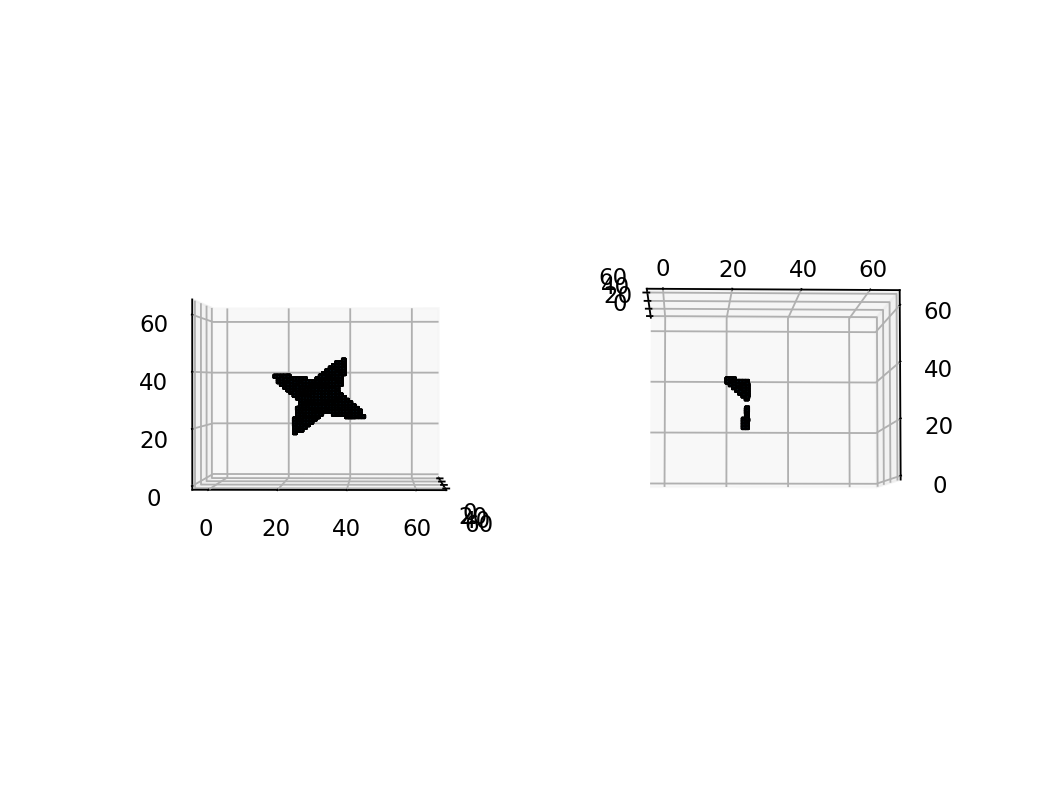

In [23]:
voxels = np.load('./data/' + name + '_voxel_entire_carved.npy')
voxels_interior = np.load('./data/' + name + '_voxel_interior_carved.npy')

resolution = 64


fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.voxels(voxels, edgecolor='k')
ax2.voxels(voxels_interior, edgecolor='k')
plt.show()